# Load a snapshot

In [1]:
from darepo.interface import ArepoSnapshot
fp = "/data/cbyrohl/TNGdata/TNG50-4/output/snapdir_042"
snp = ArepoSnapshot(fp)

/Header NumPart_ThisFile has different values.


# Get familiar with a snapshot

## Header data and alike
The snapshot contains a dictionary for the AREPO simulation header, config and parameters in its namespace. We can e.g. inspect the header:

In [2]:
snp.header

{'BoxSize': 35000.0,
 'Composition_vector_length': 0,
 'Flag_Cooling': 1,
 'Flag_DoublePrecision': 0,
 'Flag_Feedback': 1,
 'Flag_Metals': 0,
 'Flag_Sfr': 1,
 'Flag_StellarAge': 0,
 'Git_commit': b'unknown',
 'Git_date': b'unknown',
 'HubbleParam': 0.6774,
 'MassTable': array([0.        , 0.01573723, 0.        , 0.00293826, 0.        ,
        0.        ]),
 'NumFilesPerSnapshot': 11,
 'NumPart_ThisFile': array([[1783426, 1845988,       0, 1918983,   40338,     303],
        [1699979, 1766137,       0, 1851405,   31727,     306],
        [1701346, 1756764,       0, 1748680,   27667,     302],
        [1774641, 1847539,       0, 1809609,   30550,     316],
        [1696770, 1759893,       0, 1730103,   25341,     315],
        [1710133, 1774249,       0, 1747408,   28047,     306],
        [1697938, 1759720,       0, 1730037,   22568,     343],
        [1779646, 1858632,       0, 1814745,   27837,     341],
        [1710163, 1769841,       0, 1747872,   29342,     283],
        [1698500

Note that only keys that are the same across all snapshot snap_\*\*\*.hdf5 are the copied over. Some keys change for the individual files, e.g. for 'NumPart_ThisFile'. In this case, the entries are stacked along the first axis, so that we have access to all information:

In [3]:
snp.header['NumPart_ThisFile']

array([[1783426, 1845988,       0, 1918983,   40338,     303],
       [1699979, 1766137,       0, 1851405,   31727,     306],
       [1701346, 1756764,       0, 1748680,   27667,     302],
       [1774641, 1847539,       0, 1809609,   30550,     316],
       [1696770, 1759893,       0, 1730103,   25341,     315],
       [1710133, 1774249,       0, 1747408,   28047,     306],
       [1697938, 1759720,       0, 1730037,   22568,     343],
       [1779646, 1858632,       0, 1814745,   27837,     341],
       [1710163, 1769841,       0, 1747872,   29342,     283],
       [1698500, 1771385,       0, 1734398,   25917,     321],
       [1694282, 1772852,       0, 1849760,   24104,     318]],
      dtype=int32)

## Particle data

snp.datadict holds all the particle data stacked to a virtual single array per field via dask arrays.

In [4]:
print(snp.datadict.keys())

dict_keys(['PartType0', 'PartType1', 'PartType3', 'PartType4', 'PartType5'])


Let's list all fields available for the respective particle species.

In [5]:
for k,p in snp.datadict.items():
    print("Species:",k)
    print(p.keys())
    print()

Species: PartType0
dict_keys(['Coordinates', 'Density', 'ElectronAbundance', 'GFM_Metallicity', 'InternalEnergy', 'Masses', 'ParticleIDs', 'StarFormationRate', 'Velocities'])

Species: PartType1
dict_keys(['Coordinates', 'ParticleIDs', 'Velocities'])

Species: PartType3
dict_keys(['ParentID', 'TracerID'])

Species: PartType4
dict_keys(['Coordinates', 'GFM_InitialMass', 'GFM_Metallicity', 'GFM_StellarFormationTime', 'Masses', 'ParticleIDs', 'Potential', 'StellarHsml', 'Velocities'])

Species: PartType5
dict_keys(['BH_BPressure', 'BH_CumEgyInjection_QM', 'BH_CumEgyInjection_RM', 'BH_CumMassGrowth_QM', 'BH_CumMassGrowth_RM', 'BH_Density', 'BH_HostHaloMass', 'BH_Hsml', 'BH_Mass', 'BH_Mdot', 'BH_MdotBondi', 'BH_MdotEddington', 'BH_Pressure', 'BH_Progs', 'BH_U', 'Coordinates', 'Masses', 'ParticleIDs', 'Potential', 'Velocities'])



All this data is held on harddrive. With the above snapshot instance, we however have convenient way to access the data with dask.

# Using snapshot data

A field behaves very similar to a numpy array. Let's say we want to calculate the mean mass of gas cells in the simulation. Just as in numpy this would be:

In [6]:
mass = snp.datadict["PartType0"]["Masses"]
task = mass.sum()

Note that all objects remain 'virtual', they are not calculated or loaded from disk but merely the required instructions are encoded into tasks.

In [7]:
mass

dask.array<array, shape=(18946824,), dtype=float32, chunksize=(18946824,), chunktype=numpy.ndarray>

In [8]:
task

dask.array<sum-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

We can calculate the respective operations by applying the *.compute()* method to the task.

In [9]:
task.compute()

57044.957

Let's do a poor man's projection of the simulation in dask.

In [10]:
import dask.array as da
import numpy as np
coords = snp.datadict["PartType0"]["Coordinates"]
x = coords[:,0]
y = coords[:,1]
result = da.histogram2d(x,y,bins=[np.linspace(0,35000,128),np.linspace(0,35000,128)])
slcmap = result[0].compute()

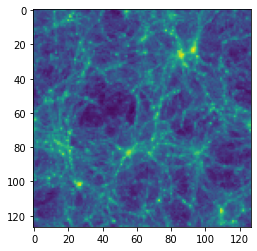

In [11]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.imshow(slcmap,norm=LogNorm())
plt.show()

# Scaling up

Until now, we have applied our framework to a very small simulation. Let's say we have a very large simulation. We could still run it with the above snippets and it would probably work: Dask chunks up work into pieces that can be calculated in parallel or/and sequentially depending on available resources. So even if the *mass* array from above does not fit into memory, the *mass.sum().compute()* will chunk the operation up in a way that the task can be calculated.

Rather than sequentially calculating bigger tasks, we want to do it in parallel. For this, we have different advanced dask schedulers available. Here, we use the most straight forward distributed scheduler *distributed*. Usually, we would start a scheduler and then connect new workers (e.g. running on compute/backend nodes of HPC clusters). We can then interactively leverage the power of the connected resources. For this example, we however just use the same API, but remain local. See [here](http://distributed.dask.org/en/stable/) for more details.

In [12]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4,threads_per_worker=1,dashboard_address=':8765')
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8765/status,
Dashboard: http://127.0.0.1:8765/status,Workers: 4
Total threads: 4,Total memory: 31.35 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45261,Workers: 4
Dashboard: http://127.0.0.1:8765/status,Total threads: 4
Started: Just now,Total memory: 31.35 GiB
Comm: tcp://127.0.0.1:37093,Total threads: 1
Dashboard: http://127.0.0.1:46807/status,Memory: 7.84 GiB
Nanny: tcp://127.0.0.1:42659,


We can now perform the same operations, but it is performed on distributed processes (local and remote!).